In [ ]:
'''
----------------------------------------------
Generating Epsilon-Delta curves

last updated: 06/10/2022
----------------------------------------------
The method used here are: 
FFT-Fei, FFT-Gopi, Saddlepoint Accountant, 
Moments Accountant.
----------------------------------------------
'''

KL= 0.006386136344532448
0.0


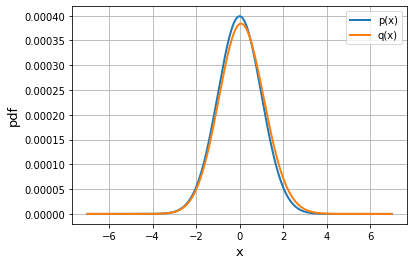

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Egamma_bounds import pq_upper
# from Egamma_bounds import pq_lower
from fft_accountant import fft_ConvN
# We first set parameters

composition = 500
sen = 1
subsampling = 0.1
C=1
c_type='l2'
noise_type='gaussian'

if noise_type == "cactus":
    filename = ('TestData/cactusM_s%.1f_%s_c%.2f_x.csv' %(sen,c_type,C))
    x = np.genfromtxt(filename, dtype=np.float32)
    x_grid = x.reshape(-1)
    
    filename = ('TestData/cactusM_s%.1f_%s_c%.2f_p.csv' %(sen,c_type,C))
    p = np.genfromtxt(filename, dtype=np.float32)
    p = p.reshape(len(p),1)
    
    n=int(1/(x[1]-x[0]))
    x_max=max(x_grid)
    po = p[0:-sen*n-1]
    print(np.shape(po))
    qo = subsampling*p[sen*n+1:]+(1-subsampling)*po
    print(np.shape(qo))

else:
    
    if noise_type=="gaussian":
        sigma=np.sqrt(C)
        f = lambda x: 1/np.sqrt(2*np.pi)/sigma*np.exp(-x**2/2/sigma**2)

    if noise_type == "laplace":
        b = np.sqrt(C/2)
        f = lambda x:1/2/b*np.exp(-np.abs(x)/b)
    
    x_max = sigma*7
    x_step_size=1e-3
    n = int(1/x_step_size)
    x_grid = np.arange(-x_max, x_max,x_step_size)
    po = np.array([f(X) for X in x_grid])*x_step_size
    qo = subsampling*np.array([f(X) for X in x_grid-sen])*x_step_size+(1-subsampling)*po
    
KL = np.sum(po*np.log(po/qo))
print("KL=",KL)

plt.figure

plt.plot(x_grid, po,label = ("p(x)"),linewidth=2)
plt.plot(x_grid, qo,label = ("q(x)"),linewidth=2)

plt.xlabel(r"x",fontsize=13)
plt.ylabel(r"pdf",fontsize=13)
plt.legend(loc='best')
plt.grid()

Eg = lambda gamma: np.sum(np.maximum(0,po-gamma*qo))

print(Eg(6))

# Next, we sample the Egamma curve uniformly
if noise_type == "gaussian":
    if subsampling !=1:
        rate = po/qo
        gamma_max = np.max(rate)
        gamma_min = np.min(rate)
    else:
        gamma_max = np.min(10,np.exp(composition*KL*3))
else:
    rate = po/qo
    gamma_max = np.max(rate)
    gamma_min = np.min(rate)

l_step_size = 1e-3
l_grid = np.arange(np.log(gamma_min),np.log(gamma_max),l_step_size)



AttributeError: module 'numpy' has no attribute 'ifft'

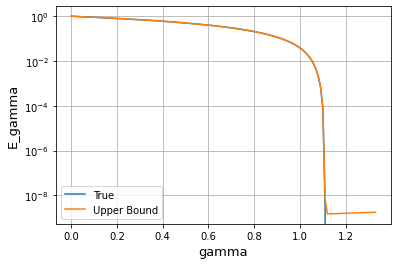

In [2]:
'''
----------------------------------------------
FFT-Fei:
----------------------------------------------
Step 1: Obtain a E-gamma curve on gamma_grid via function Eg(gamma_grid) -> Eg_grid

Step 2(a): Obtain distribution pair upper bounding Eg_grid -> (p2,q2)
      (b): Use (eps_grid,p2) as a random variable L_low 
      (c): Perform FFT and iFFT to get convoluted (l_grid_padding,fLConvFFT_array2)
      (d): Compute the Egamma_upper()

Step 3(a): Obtain distribution pair lower bounding Eg_grid -> (p3,q3)
      (b): Use (eps_grid,p3) as a random variable L_low 
      (c): Perform FFT and iFFT to get convoluted (l_grid_padding,fLConvFFT_array3)
      (d): Compute the Egamma_lower()
----------------------------------------------
'''

gamma_grid = np.exp(l_grid)

# Again, we use Egamma2 for verifing the result, it should be an upper bound of the true Egamma curve.
p2,q2 = pq_upper(Eg,gamma_grid);

# Lastly, we get a lower bounding discrete model (p3,q3).
Egslope = lambda gamma: -sum([qo[i] if po[i]>gamma*qo[i] else 0 for i in range(0,len(po))])
# p3,q3 = pq_lower(Eg,Egslope,gamma_grid);

plt.figure
gamma_test2 = np.arange(0,gamma_max*1.2,1e-2)
plt.semilogy(gamma_test2,[Eg(gamma) for gamma in gamma_test2],label='True')

Egamma_upper = lambda gamma: np.sum(np.maximum(0,p2-gamma*q2))
Eg_array_upper2 = [Egamma_upper(gamma) for gamma in gamma_test2]
plt.semilogy(gamma_test2,Eg_array_upper2,label='Upper Bound')

# Egamma_lower = lambda gamma: np.sum(np.maximum(0,p3-gamma*q3))
# Eg_array_lower = [Egamma_lower(gamma) for gamma in gamma_test2]
# plt.semilogy(gamma_test2,Eg_array_lower,label='Lower Bound')

plt.xlabel(r"gamma",fontsize=13)
plt.ylabel(r"E_gamma",fontsize=13)
plt.legend(loc='best')
plt.grid()

'''
Step 2
There's a minor problem with the upper bounding model, since the last value has q2(end)=0 but
p2(end)>0. This correspondings to an infinite value of L, which doesn't show up in the grid.
We can deal with this by slicing off the last value, then adding back to delta the probability 
that any of the compositions happens to hit the last value. 
This occurs with probability 1-(1-p2(end))^composition
'''
l_grid_padding,fLConvFFT_array2 = fft_ConvN(l_grid,p2[1:-1],composition)
print(l_grid_padding)
print(fLConvFFT_array2)
delta_FFT_upper_bd = lambda eps: np.sum(fLConvFFT_array2*np.maximum(0,1-np.exp(eps-l_grid_padding)))+(1-(1-p2[-1])^composition)

'''
Step 3
We can actually avoid all FFT shifting (and normalization) if we zero-pad at the end of 
the vector, rather than on both sides. In fact the fft function will automatically do this
if we just add a second argument with the desired length
'''



[[0.07110143 0.00671091]
 [0.86515552 0.42700486]
 [0.00122049 0.16761062]
 [0.32393348 0.46326829]
 [0.03213146 0.55743488]
 [0.56884947 0.21047938]
 [0.12032806 0.54067184]
 [0.19018907 0.24827727]
 [0.65986767 0.16846328]
 [0.97224909 0.76454926]]
[[0 2]
 [4 2]
 [4 9]
 [8 0]
 [1 9]
 [1 8]]


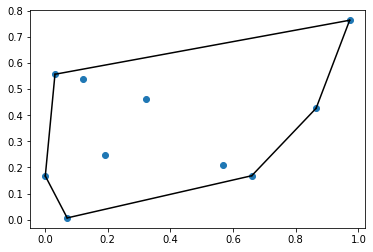

In [5]:
from scipy.optimize import fsolve
from scipy.spatial import ConvexHull
import numpy as np
rng = np.random.default_rng()
a = rng.random((10))
b = rng.random((10))
print((np.stack((a,b),axis=1)))
hull=ConvexHull(np.stack((a,b),axis=1))
print(hull.simplices)

import matplotlib.pyplot as plt
plt.plot(a[:], b[:], 'o')
for simplex in hull.simplices:
    plt.plot(a[simplex], b[simplex], 'k-')
